In [1]:
import sys
import os
sys.path.append(sys.path[0] + "/..")

%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from jupyterthemes import jtplot
import datetime
jtplot.style()

In [2]:
# directory = '../experiments/data/raw/DJA-stocks'

# dja = []
# for filename in os.listdir(directory):
#     if filename.endswith(".csv"):
#         df = pd.read_csv(directory + "/" + filename)
#         df.name = filename.split('-')[1]
#         df['name'] = df.name
#         df.columns = df.columns.str.replace('\d+', '').str.replace('.', '').str.replace(' ', '')
#         dja.append(df)
        
# df_dja = pd.concat(dja, axis=0)
# df_dja.to_csv('../experiments/data/raw/DJA-2000-2020.csv')

In [3]:
# df_dja = df_dja.drop(['volume'], axis=1)
# df_dja.to_csv('../experiments/data/interim/DJA-2000-2020-clean.csv')

In [4]:
df_dja = pd.read_csv('../experiments/data/interim/DJA-2000-2020-clean.csv')
df_dja['date'] = pd.to_datetime(df_dja['date'])
df_dja.set_index('date', inplace=True)
df_dja = df_dja.drop('Unnamed: 0', axis=1)
df_dja.head()

,open,high,low,close,name
date,,,,,
2000-05-11,101.37,104.25,99.00,102.81,AAPL
2000-05-12,106.00,110.50,104.77,107.62,AAPL
2000-05-15,108.06,108.06,100.12,101.00,AAPL
2000-05-16,104.52,109.06,102.75,105.69,AAPL
2000-05-17,103.62,103.69,100.37,101.37,AAPL


In [5]:
df_dja = df_dja[(df_dja['name'] != 'V') & (df_dja['name'] != 'DOW')]

In [6]:
from hedgepy.core import build_series, build_network_time_series
from hedgepy.utils import write_series, read_series, read_data

# dja_series = build_series(df=df_dja, ticker_col_name='name', rolling_window=90, detrend=True, coalesce=True)

In [7]:
# write_series(dja_series, file_name='DJA-2000-2020-rolling-90d-dcor.json')
dja_series = read_series('DJA-2000-2020-rolling-90d-dcor.json')

In [8]:
# not sure why first df is all nans... will have to loops over dict and drop if df contains any nans
dja_series.pop(pd.Timestamp('2000-09-18 00:00:00'))

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,IBM,...,NKE,PFE,PG,RTX,TRV,UNH,VZ,WBA,WMT,XOM
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_dja_index = pd.read_csv('../experiments/data/raw/DJA-index/DJA-2000-2020-index.csv')
df_dja_index['Date'] = pd.to_datetime(df_dja_index['Date'])
df_dja_index.set_index('Date', inplace=True)
df_dja_index.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-05-11,10369.269531,10575.099609,10369.269531,10545.969727,10545.969727,185720000
2000-05-12,10549.059570,10673.790039,10543.919922,10609.370117,10609.370117,137770000
2000-05-15,10606.969727,10811.549805,10605.259766,10807.780273,10807.780273,155810000
2000-05-16,10816.009766,10971.240234,10816.009766,10934.570313,10934.570313,181920000
2000-05-17,10930.639648,10930.639648,10752.610352,10769.740234,10769.740234,169570000


In [10]:
from hedgepy.centrality import global_degree_centrality, global_eigencentrality

nx_ts_soft = build_network_time_series(dja_series, soft_threshold=True)

In [11]:
nx_ts_02 = build_network_time_series(dja_series, soft_threshold=False, corr_threshold=0.2)
nx_ts_03 = build_network_time_series(dja_series, soft_threshold=False, corr_threshold=0.3)
nx_ts_04 = build_network_time_series(dja_series, soft_threshold=False, corr_threshold=0.4)
nx_ts_05 = build_network_time_series(dja_series, soft_threshold=False, corr_threshold=0.5)
nx_ts_06 = build_network_time_series(dja_series, soft_threshold=False, corr_threshold=0.6)
nx_ts_07 = build_network_time_series(dja_series, soft_threshold=False, corr_threshold=0.7)
nx_ts_08 = build_network_time_series(dja_series, soft_threshold=False, corr_threshold=0.8)
nx_ts_09 = build_network_time_series(dja_series, soft_threshold=False, corr_threshold=0.9)

In [12]:
nx_ts_list = [nx_ts_02, nx_ts_03, nx_ts_04, nx_ts_05, nx_ts_06, nx_ts_07, nx_ts_08, nx_ts_09]

df_list = [global_degree_centrality(G) for G in nx_ts_list]
df_dc = pd.concat(df_list, axis=1)

In [13]:
df_ec = global_eigencentrality(nx_ts_soft)

In [14]:
col_names = [f'dcor > {i}' for i in [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]]
df_dc.columns = col_names

C:\Users\maya.benowitz\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


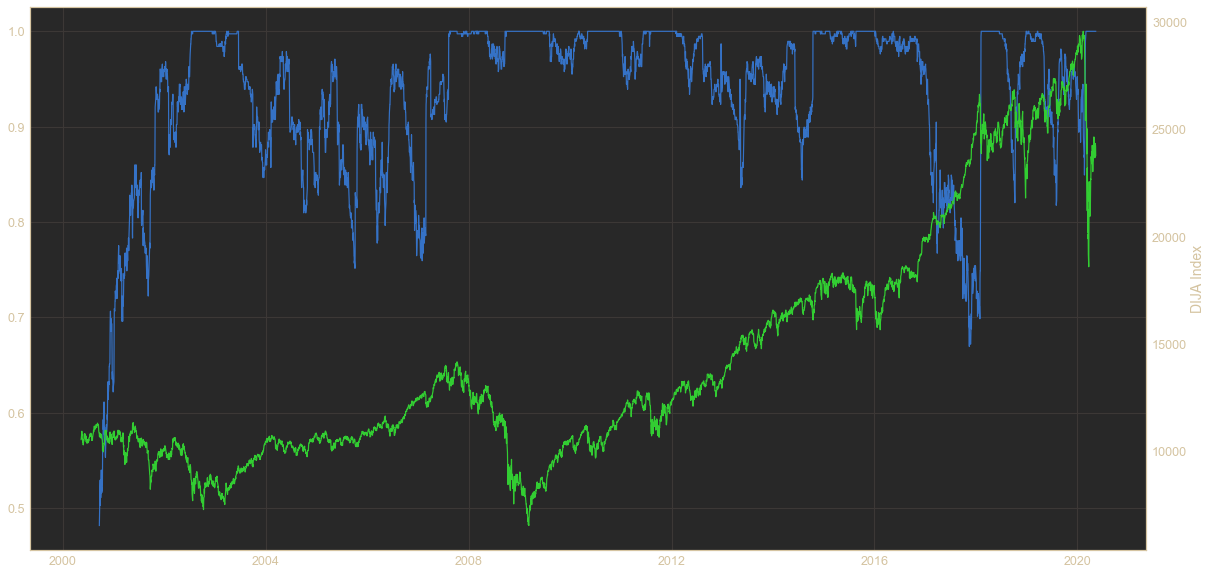

In [15]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_dc['dcor > 0.3'])
ax2 = ax.twinx()
ax2.plot(df_dja_index['Close'], color='limegreen')
ax2.set_ylabel('DIJA Index', fontsize=14)
ax2.grid(False)

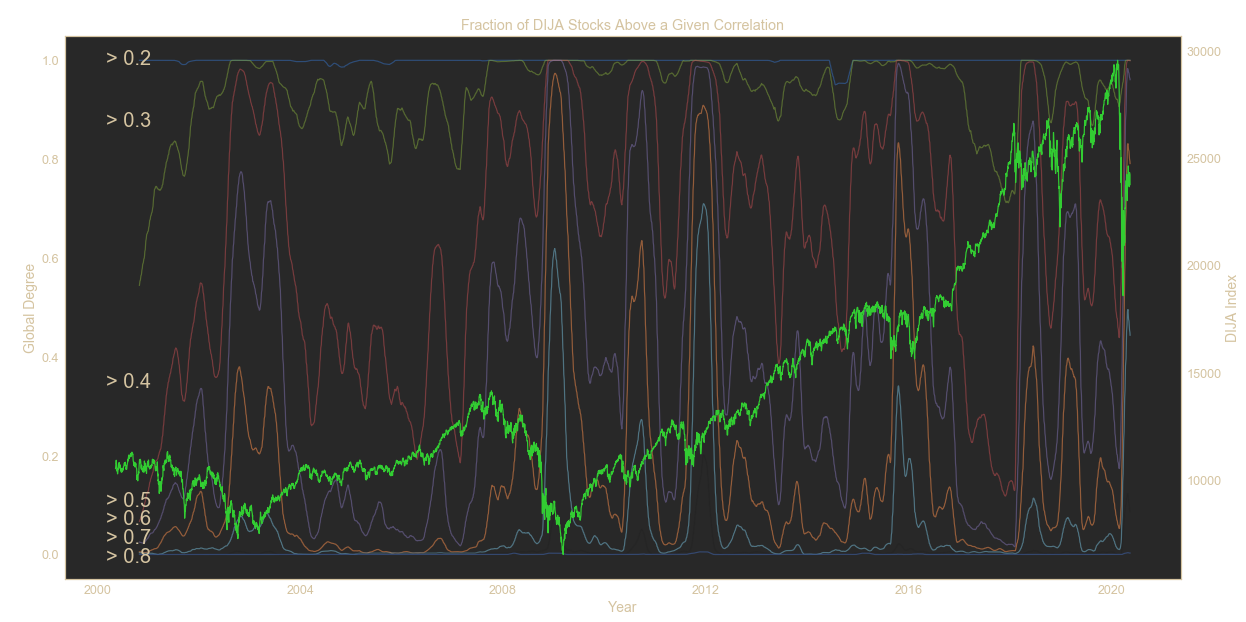

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
for col in df_dc.columns:
    ax.plot(df_dc[col].rolling(30).mean(), alpha=0.5)

ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Global Degree", fontsize=14)
ax.set_title('Fraction of DIJA Stocks Above a Given Correlation')
ax.grid(False)
ax.annotate('> 0.2',
            xy=(0.085, .92), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)
ax.annotate('> 0.3',
            xy=(0.085, .82), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)
ax.annotate('> 0.4',
            xy=(0.085, .40), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)
ax.annotate('> 0.5',
            xy=(0.085, .21), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)
ax.annotate('> 0.6',
            xy=(0.085, .18), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)
ax.annotate('> 0.7',
            xy=(0.085, .15), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)
ax.annotate('> 0.8',
            xy=(0.085, .12), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)

ax2 = ax.twinx()
ax2.plot(df_dja_index['Close'], color='limegreen')
ax2.set_ylabel('DIJA Index', fontsize=14)
ax2.grid(False)

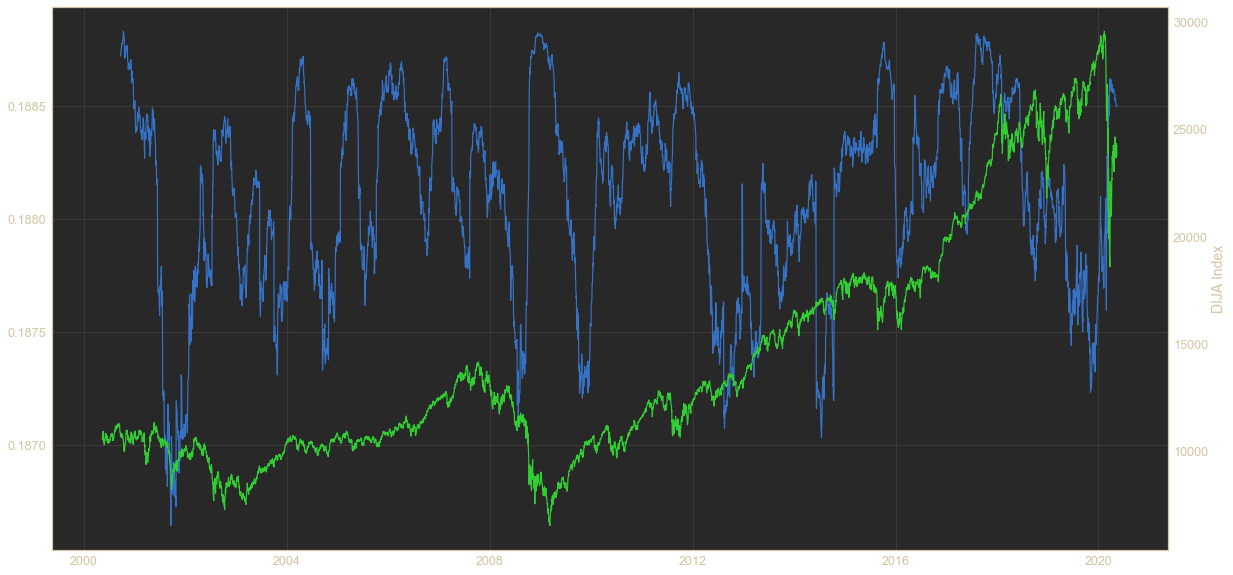

In [17]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_ec)
ax2 = ax.twinx()
ax2.plot(df_dja_index['Close'], color='limegreen')
ax2.set_ylabel('DIJA Index', fontsize=14)
ax2.grid(False)

In [18]:
df_ec['pct_change'] = df_ec[['global_eigencentrality']].pct_change()
df_ec.dropna(inplace=True)

In [19]:
def optimize_OneClassSVM(X, n):
    print('searching for optimal hyperparameters...')
    nu = np.linspace(start=1e-5, stop=1e-2, num=n)
    gamma = np.linspace(start=1e-6, stop=1e-3, num=n)
    opt_diff = 1.0
    opt_nu = None
    opt_gamma = None
    for i in range(len(nu)):
        for j in range(len(gamma)):
            classifier = OneClassSVM(kernel="rbf", nu=nu[i], gamma=gamma[j])
            classifier.fit(X)
            label = classifier.predict(X)
            p = 1 - float(sum(label == 1.0)) / len(label)
            diff = math.fabs(p - nu[i])
            if diff < opt_diff:
                opt_diff = diff
                opt_nu = nu[i]
                opt_gamma = gamma[j]
    return opt_nu, opt_gamma

In [20]:
X_train = df_ec[['pct_change']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(np_scaled).dropna()

opt_nu, opt_gamma = optimize_OneClassSVM(X_train, n=20)

searching for optimal hyperparameters...


In [21]:
print(opt_nu)
print(opt_gamma)

0.007896842105263159
5.357894736842106e-05


In [233]:
model = OneClassSVM(nu=0.01, kernel='rbf', gamma=1/len(df_ec))
model.fit(X_train)
anomalies = pd.Series(model.predict(X_train), index=df_ec.index)

In [23]:
1/np.sqrt(len(df_ec))

0.014226319992543996

In [234]:
df_ec['anomalies'] = anomalies
df_ec['DJA'] = df_dja_index['Close']

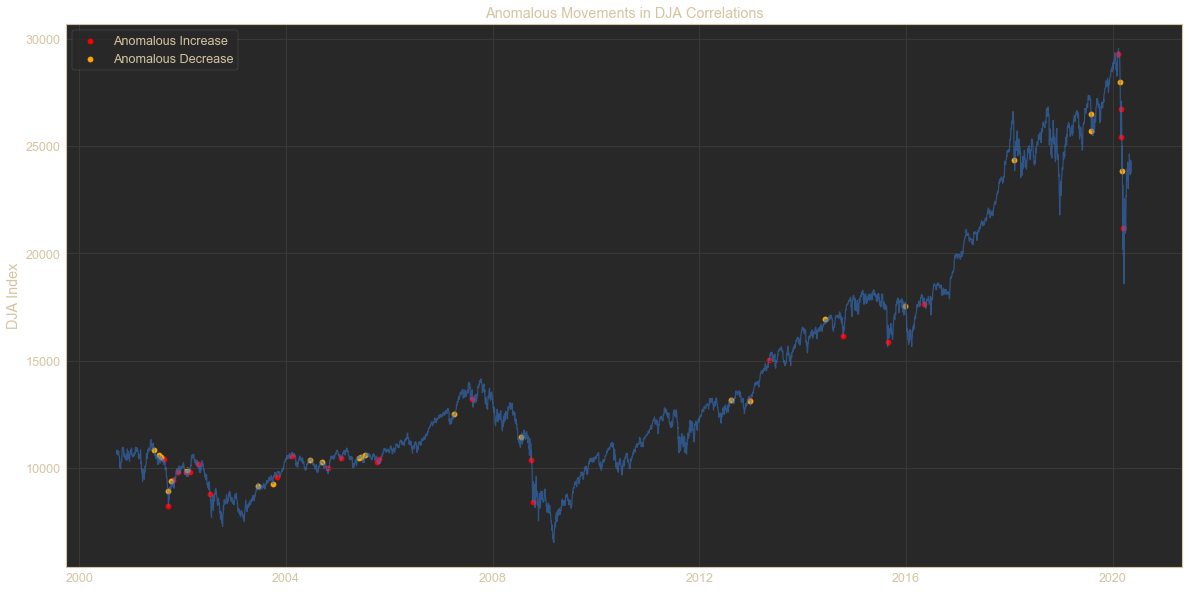

In [235]:
a = df_ec.loc[(df_ec['anomalies'] == -1)]
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_ec.index, df_ec['DJA'], alpha=0.6)

b = a.loc[a['pct_change'] > 0]
c = a.loc[a['pct_change'] < 0]

bsize = np.abs([(i*10000)**1.5 for i in b['pct_change'].tolist()])
csize = np.abs([(i*10000)**1.5 for i in c['pct_change'].tolist()])
ax.scatter(df_ec['DJA'][(df_ec['anomalies']==-1) & (df_ec['pct_change'] > 0)].index, df_ec['DJA'][(df_ec['anomalies']==-1) & (df_ec['pct_change'] > 0)], label='Anomalous Increase', color='red')
ax.scatter(df_ec['DJA'][(df_ec['anomalies']==-1) & (df_ec['pct_change'] < 0)].index, df_ec['DJA'][(df_ec['anomalies']==-1) & (df_ec['pct_change'] < 0)], label='Anomalous Decrease', color='orange')

ax.set_title('Anomalous Movements in DJA Correlations')
ax.set_ylabel('DJA Index')
ax.legend()

# plt.savefig('../experiments/resources/dja-anomalies-2000-2020')

In [26]:
a['2001']

,global_eigencentrality,pct_change,anomalies,DJA
2001-06-13,0.187764,-0.002157,-1,10871.620117
2001-07-19,0.187343,-0.001608,-1,10610.000000
2001-07-31,0.187074,-0.000794,-1,10522.809570
2001-08-24,0.187112,0.001580,-1,10423.169922
2001-09-17,0.186644,-0.001711,-1,8920.700195
2001-09-21,0.187039,0.001169,-1,8235.809570
2001-10-11,0.186776,-0.000792,-1,9410.450195
2001-10-25,0.187175,0.002395,-1,9462.900391
2001-11-23,0.187056,0.000674,-1,9959.709961
2001-11-30,0.187311,0.001440,-1,9851.559570


In [139]:
len(a)

50

In [28]:
df_dja_index['returns'] = df_dja_index['Close'].pct_change()
df_dja_index.dropna(inplace=True)

In [140]:
def get_drawdowns(price):
    pmin_pmax = (price.diff(-1) > 0).astype(int).diff()
    pmax = pmin_pmax[pmin_pmax == 1]
    pmin = pmin_pmax[pmin_pmax == -1]
    
    if pmin.index[0] < pmax.index[0]:
        pmin = pmin.drop(pmin.index[0])
    if pmin.index[-1] < pmax.index[-1]:
        pmax = pmax.drop(pmax.index[-1])

    dd = ((np.array(price[pmin.index])) - np.array(price[pmax.index])) / np.array(price[pmax.index])
    dur = [np.busday_count(p1.date(), p2.date()) for p1, p2 in zip(pmax.index, pmin.index)]
    d = {'Date':pmax.index, 'drawdown':dd, 'd_start': pmax.index, 'd_end': pmin.index, \
             'duration': dur}    
    
    df_d = pd.DataFrame(d).set_index('Date')
    df_d.index = pd.to_datetime(df_d.index, format='%Y/%m/%d')
    df_d = df_d.sort_values(by='drawdown')
    df_d['rank'] = list(range(1,df_d.shape[0]+1))
    
    return df_d

In [141]:
df_d = get_drawdowns(df_dja_index['Close'])

In [142]:
df_d

,drawdown,d_start,d_end,duration,rank
Date,,,,,
2008-09-30,-0.221136,2008-09-30,2008-10-10,8,1
2001-09-05,-0.179150,2001-09-05,2001-09-21,12,2
2020-03-10,-0.152591,2020-03-10,2020-03-12,2,3
2020-02-19,-0.134206,2020-02-19,2020-02-28,7,4
2020-03-13,-0.129265,2020-03-13,2020-03-16,1,5
2020-03-04,-0.119592,2020-03-04,2020-03-09,3,6
2015-08-17,-0.107080,2015-08-17,2015-08-25,6,7
2008-11-18,-0.103559,2008-11-18,2008-11-20,2,8
2002-07-17,-0.098349,2002-07-17,2002-07-23,4,9


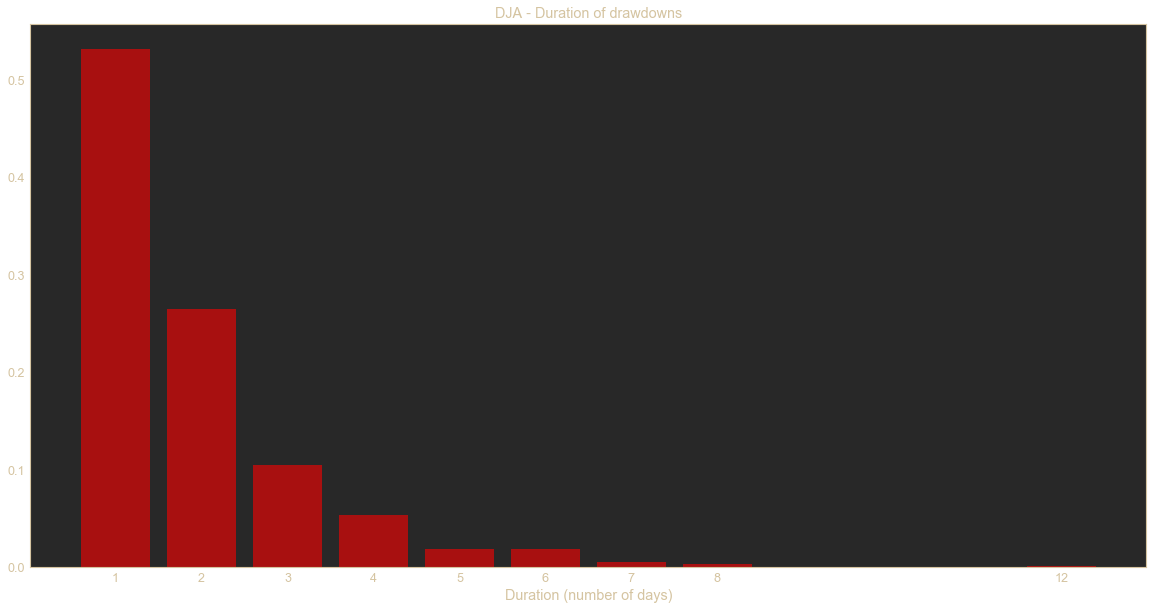

In [32]:
from collections import defaultdict
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

l_dict_dd = []

max_dd = max(abs(df_d['drawdown']))
m = round(max_dd+0.01,2)
bins = np.linspace(-m, m, 800)
d = {}
for i in range(1, len(bins)+1):
    d[i] = bins[i-1]
disc = np.digitize(x=df_d['drawdown'], bins=bins)
d1 = defaultdict(int)
for i in disc:
    d1[d[i]] += 1
l_dict_dd.append(d1)
plt.bar(x=df_d['duration'].value_counts().index, height=df_d['duration'].\
    value_counts()/df_d['duration'].shape[0], color='red', alpha=0.6)
plt.xticks(df_d['duration'].value_counts().index)
plt.title('DJA - Duration of drawdowns')
plt.xlabel('Duration (number of days)')
plt.grid()
plt.show()

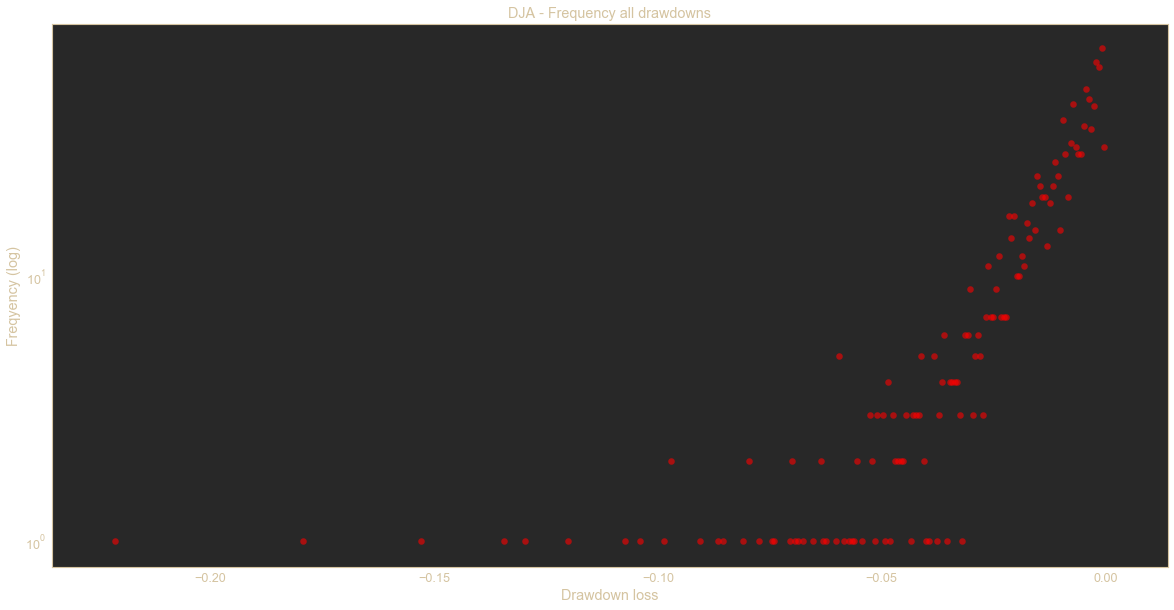

In [33]:
rcParams['figure.figsize'] = 20, 10
for d1 in l_dict_dd:
    df_d_bins = pd.DataFrame(list(d1.items()))
    df_d_bins.columns = ['drawdown', 'n']
    plt.scatter(df_d_bins['drawdown'], df_d_bins['n'], s=40, color='red', alpha=0.6)
    plt.yscale('log')
    df_d_bins_reg = df_d_bins[df_d_bins['drawdown']>-0.08]
#     m, c = np.polyfit(df_d_bins_reg['drawdown'], np.log(df_d_bins_reg['n']), 1)
#     y_fit = np.exp(m*df_d_bins['drawdown'] + c)
    plt.ylim(bottom=10**-.1)
#     plt.plot(df_d_bins['drawdown'], y_fit, color='black', ls='dashed')
    plt.title('DJA - Frequency all drawdowns')
    plt.xlabel('Drawdown loss')
    plt.ylabel('Freqyency (log)')
    plt.grid()
    plt.show()

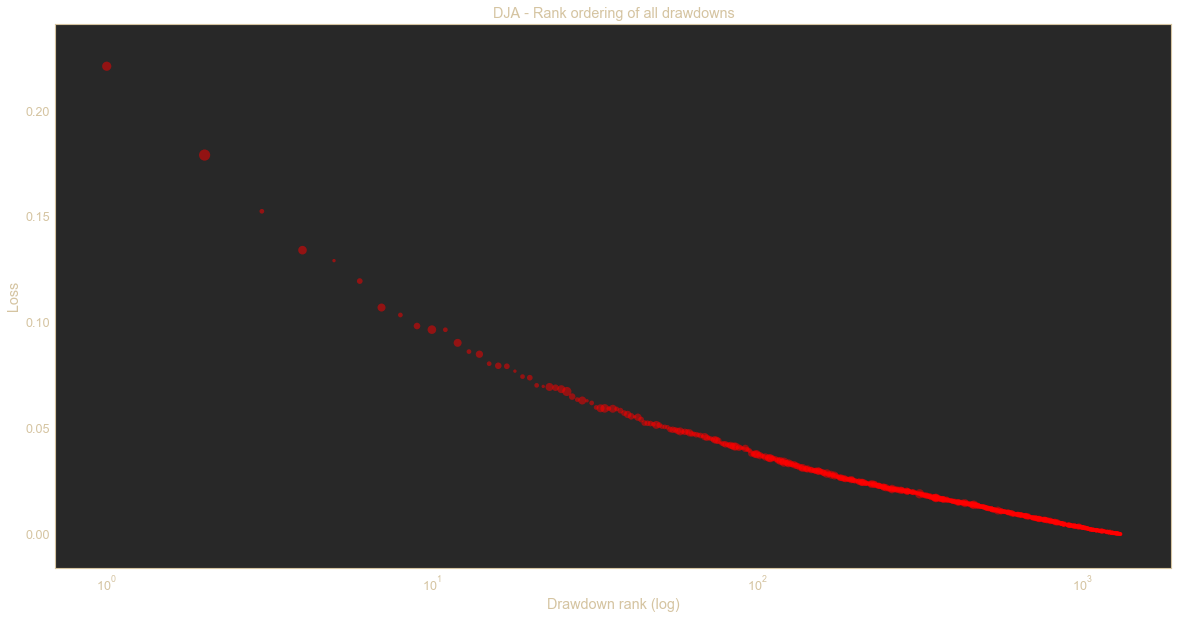

In [34]:
rcParams['figure.figsize'] = 20, 10
plt.scatter(df_d['rank'], abs(df_d['drawdown']), s=10*df_d['duration'], alpha=0.5,\
            color='red')
plt.xscale('log')
plt.title('DJA - Rank ordering of all drawdowns')
plt.xlabel('Drawdown rank (log)')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [143]:
def get_dislocations(df_d, q):
    q = 1 - q
    crashes = df_d[df_d['drawdown'] < df_d.quantile(q)[0]]
    return crashes

dislocations = get_dislocations(df_d, q=0.985)
dislocations

,drawdown,d_start,d_end,duration,rank
Date,,,,,
2008-09-30,-0.221136,2008-09-30,2008-10-10,8,1
2001-09-05,-0.179150,2001-09-05,2001-09-21,12,2
2020-03-10,-0.152591,2020-03-10,2020-03-12,2,3
2020-02-19,-0.134206,2020-02-19,2020-02-28,7,4
2020-03-13,-0.129265,2020-03-13,2020-03-16,1,5
2020-03-04,-0.119592,2020-03-04,2020-03-09,3,6
2015-08-17,-0.107080,2015-08-17,2015-08-25,6,7
2008-11-18,-0.103559,2008-11-18,2008-11-20,2,8
2002-07-17,-0.098349,2002-07-17,2002-07-23,4,9


In [144]:
len(dislocations)

20

In [178]:
len(a)

50

In [326]:
def recall_score(anomalies, dislocations, pred_range, verbose=False):
    df_dist = pd.DataFrame(index=anomalies.index, columns=dislocations.index)
    
    for i in anomalies.index:
        for j in dislocations.index:
            df_dist.at[i,j] = (i-j).days
    
    hits = [df_dist[i].between(-pred_range, -1) for i in dislocations.index]
    df_hits = pd.concat(hits, axis=1)
    
    disloc_dates = dislocations.index.tolist()
    tp_fn = [True in df_hits[i].tolist() for i in disloc_dates]

    df_tpfn = pd.DataFrame(zip(disloc_dates, tp_fn))
    df_tpfn.columns = ['drawdown', 'predicted']
    
    tp = len(df_tpfn[df_tpfn['predicted'] == True])
    fn = len(df_tpfn[df_tpfn['predicted'] == False])
    
    recall = tp / (tp + fn)
    if not verbose:
        return recall, tp, fn
    if verbose:
        return print('Recall:', recall, '\n\n', df_tpfn)
            
recall_score(a, dislocations, 90, verbose=False)

(0.85, 17, 3)

In [237]:
def precision_score(anomalies, dislocations, pred_range, verbose=False):
    df_dist = pd.DataFrame(index=anomalies.index, columns=dislocations.index)
    
    for i in anomalies.index:
        for j in dislocations.index:
            df_dist.at[i,j] = (i-j).days
    
    hits = [df_dist[i].between(-pred_range, -1) for i in dislocations.index]
    df_hits = pd.concat(hits, axis=1)
    
    anom_dates = anomalies.index.tolist()
    disloc_dates = dislocations.index.tolist()
    
    fp = [True in df_hits.loc[i].tolist() for i in anom_dates]
    tp = [True in df_hits[i].tolist() for i in disloc_dates]

    df_fp = pd.DataFrame(zip(anom_dates, fp))
    df_fp.columns = ['anomalies', 'ground']
    
    df_tpfn = pd.DataFrame(zip(disloc_dates, tp))
    df_tpfn.columns = ['drawdown', 'predicted']

    fp = len(df_fp[df_fp['ground'] == False])
    tp = len(df_tpfn[df_tpfn['predicted'] == True])
    
    precision = tp / (tp + fp)
    if not verbose:
        return precision, tp, fp
    if verbose:
        return print('Precision:', precision, '\n\n', df_fp)
    
precision_score(a, dislocations, 90, verbose=False)

(0.3269230769230769, 17, 35)

In [238]:
def f_score(precision, recall, beta):
    f = (1 + beta**2) * (precision*recall)/( (beta**2 * precision) + recall )
    return f

f_score(precision_score(a, dislocations, 90)[0], recall_score(a, dislocations, 90)[0], beta=5)

0.8007246376811595

In [341]:
prec_curve = []
rec_curve = []
f_curve = []
for i in range(1, 180):
    prec_curve.append(precision_score(a, dislocations, i, verbose=False)[0])
    rec_curve.append(recall_score(a, dislocations, i, verbose=False)[0])
    f_curve.append(f_score(precision_score(a, dislocations, i)[0], recall_score(a, dislocations, i)[0], beta=5))

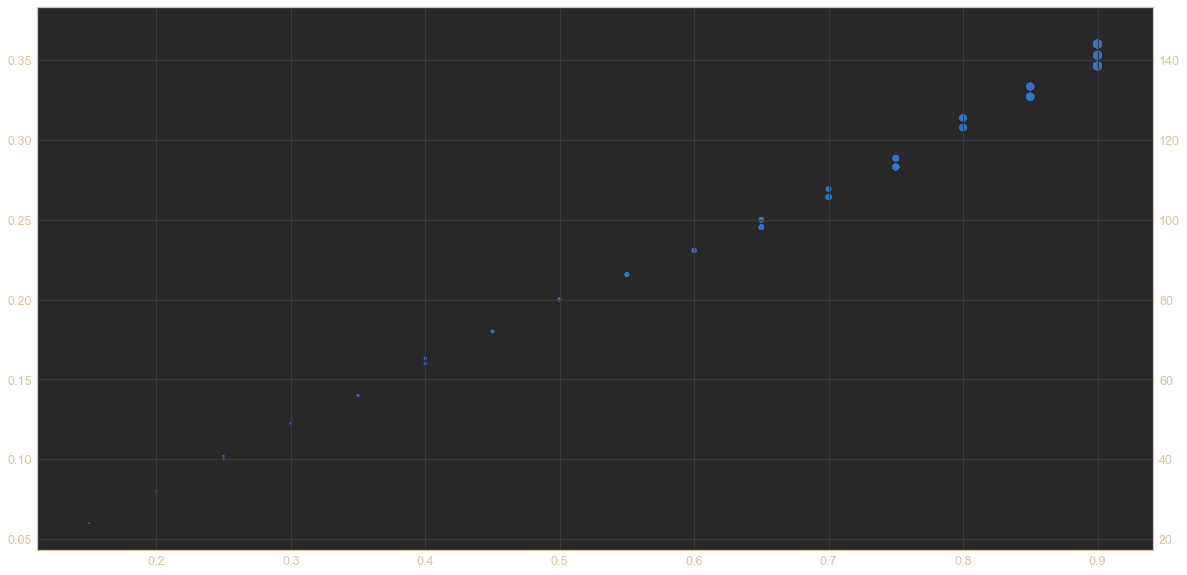

In [372]:
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(x=rec_curve, y=prec_curve, s=(np.array(f_curve)+1)**7)
ax2 = ax.twinx()
labels = [int(round(x)) for x in np.linspace(0, 180, 10)]
ax2.set_ylim(ax.get_ylim())
ax2.set_yticklabels(labels);